---
title: Batch and instance whitening
classes: wide
tags: probability ml pytorch
---

Tutorial and intuition on batch vs. instance whitening, complete with PyTorch code.
<!--more-->

Helper functions used to make plots but not important to understanding the content of this post (e.g. plotting,
reshaping, etc):

[PyTorch code available here](https://github.com/lyndond/lyndond.github
.io/blob/master/code/2021-02-23-batch-instance-whitening.ipynb){: .btn .btn--success .btn--large}

# Intro
Whitening is a fundamental concept in statistics, and turns up very often in machine learning.
E.g. it can make it a lot easier to compare/transform distributions of activations like in style transfer.
Whitening responses can also serve to efficiently propagate signal down a cascade of neural net layers.

The whitening operation is simple enough to understand geometrically: if your distribution is elliptical like a
correlated Gaussian, then it turns it spherical.
In 2D this means it turns an ellipse into a circle.
Computing it is also relatively simple: you whiten your data with respect to statistics (covariance) of the data.
The tricky part is to decide _which_ aspect of your data you should be whitening.

This short post will cover graphical intuition and code for two different kinds of whitening: batch and instance.

## Helper functions

These functions include a coloring transform, a method to de-mean channels in a tensor, tensor reshapers, and a
activation-plotting method.

In [38]:
import torch
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

torch.manual_seed(6969)

n, c, h, w = 10, 2, 512, 512
shape = n, c, h, w

def colorize(feature_map):
    """color 2D tensor white data with random covariance matrix"""
    tmp = torch.randn((c, c))
    Sigma = tmp.T @ tmp * torch.rand(1) * 5
    chol = torch.cholesky(Sigma)
    demeaned, mu = demean(feature_map)
    colored_feature_map = chol @ feature_map
    return mu + colored_feature_map

def demean(feature_map, dim=-1):
    """removes mean of tensor channels"""
    mu = torch.mean(feature_map, dim=dim, keepdim=True)
    demeaned = -mu + feature_map
    return demeaned, mu

def flatten_space(feature_map):  # squash spatial dims
    return torch.flatten(feature_map, start_dim=-2).clone()  # n x c x (h*w)

def unflatten_space(feature_map, tensor_shape=shape):  # unsquash spatial dims
    return feature_map.reshape(tensor_shape).clone()  # n x c x h x w

def flatten_batch_and_space(feature_map):  # flatten both batch and space
    return feature_map.transpose(1,0).flatten(start_dim=1).clone()  # c x (n*h*w)

def unflatten_batch_and_space(feature_map, tensor_shape=(c,n,h,w)):  # undo flatten batch + space
    return feature_map.reshape(tensor_shape).transpose(1,0).clone()  # n x c x h x w

def feature_scatter(batched_feature_maps, nrows=2, ncols=5):
    """Helper for plotting all channels' responses"""
    fig, ax = plt.subplots(nrows, ncols, squeeze=False, sharex='all', sharey='all',
                           figsize=(8,4))
    batched_squashed_feature_maps = flatten_space(batched_feature_maps)
    nmaps = len(batched_squashed_feature_maps)
    for i in range(nmaps):
        idx = np.unravel_index(i, (nrows, ncols)) if (nrows, ncols) != (1, 1) else (0, 0)
        ax[idx].scatter(batched_squashed_feature_maps[i][0,:],
                        batched_squashed_feature_maps[i][1,:], color=f'C{i}')
        ax[idx].set(title=f'n={i}' if (nrows, ncols)!=(1,1) else 'all n in batch', aspect='equal')
    ax[0, 0].set(xlabel='channel 0', ylabel='channel 1')#, xticks=[], yticks=[])
    fig.tight_layout()
    return fig, ax

## Generated data
Let's simulate activations of two convolutional filters (channels) to 10 images in a batch.
The tensor of activations is ``Size([n=10, c=2, h=256, w=256])``.
If we collapse the spatial dims, we can plot the two filter responses against each other and see how they're
correlated and distributed.

Each entry in the batch dimension ``n=0:9`` is referred to as an _instance_.
Data is created by randomly colouring the channels' responses in each instance (local covariances), then random means
are added to the data, then the _entire batch_ is randomly coloured according to some (global covariance).

shape -- nbatch, nchans, height, width: 
torch.Size([10, 2, 512, 512])


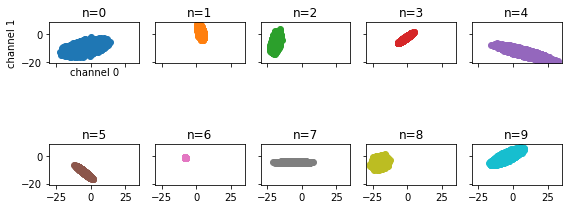

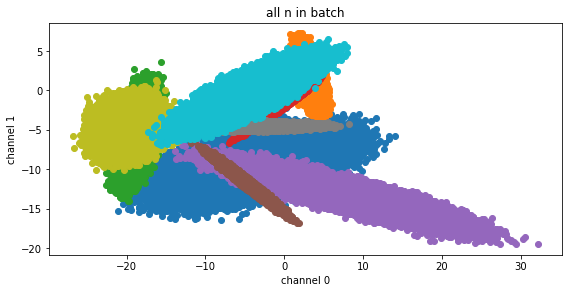

In [39]:
def get_activations():
    """Creates 2D Gaussian distributed activations, with means distributed randomly.
    """
    a = torch.randn(shape)
    a = torch.stack([colorize(flatten_space(r)) for r in a])
    a = unflatten_space(a)
    a += torch.randn((n,c,1,1)) * 10
    a = unflatten_batch_and_space(colorize(flatten_batch_and_space(a)))
    return a

activations = get_activations()

print("shape -- nbatch, nchans, height, width: ")
print(activations.shape)

feature_scatter(activations)  # code in repository
_, ax = feature_scatter(activations, nrows=1, ncols=1);

Each instance with local instance covariance is plotted in a different colour.
The global batch covariance of the data looks to be negatively correlated.

# Batch vs instance whitening
Here is the main takeaway and intuition:

**Batch whitening**: whiten all channels using each instance (image) in the batch.

**Instance whitening**: whiten all channels using single instance in the batch.

## Batch whitening
The logic for batch whitening is simple: first, turn the 4D ``nxcxhxw`` tensor into a 2D ``cx(n*h*w)`` tensor.
We then compute its covariance, and corresponding ``cxc`` whitening matrix and apply it to the de-meaned data.
Finally, we add back the mean and reshape the data back to ``nxcxhxw``.

(This could be greatly optimized but this way is easiest to understand.)

Global cov should be close to identity: 
 tensor([[1.0000e+00, 2.8164e-07],
        [2.8164e-07, 1.0000e+00]])


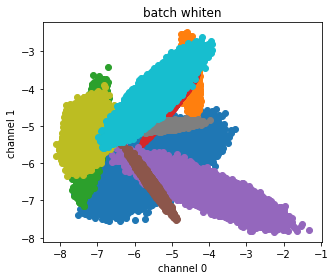

In [46]:
def batch_whiten(batch_feature_map):
    """zca whiten each feature using stats across all images in batch"""
    y = flatten_batch_and_space(batch_feature_map)
    y, mu = demean(y)
    N = y.shape[-1]
    cov = y @ y.T / (N - 1)
    u, lambduh, _ = torch.svd(cov)
    lambduh_inv_sqrt = torch.diag(lambduh**(-.5))
    zca_whitener = u @ lambduh_inv_sqrt @ u.T
    z = zca_whitener @ y
    return unflatten_batch_and_space(mu + z)

batch_whitened = flatten_batch_and_space(batch_whiten(activations))
_, ax = feature_scatter(batch_whiten(activations), nrows=1, ncols=1)
ax[0,0].set(title='batch whiten');

demean_batch_whitened, _ = demean(batch_whitened)
print('Global cov should be close to identity: \n',
      demean_batch_whitened @ demean_batch_whitened.T / batch_whitened.shape[1])

The data has been rotated and scaled, and now has identity covariance _in aggregate_.
Clearly despite it having identity covariance it doesn't look like a circular Gaussian at all.
This is cheaper to compute relative to instance whitening, and the signal is more tame to work with now tha it's been
transformed.

## Instance whitening

The logic here is similar to before.
We start with a 4D ``nxcxhxw`` tensor, and reshape it now to a **3D** (not 2D) ``nxcx(h*w)`` tensor.
Then, we compute the covariance and whitening transform for _each instance_ in the batch dimension.
So there are now ``n`` tensors each with size ``cx(h*w)`` with which to compute covariances and whitening transforms.
These ``cxc`` covariances describe the local covariances (coloured ellipses) shown above.

Global cov should NOT be identity: 
 tensor([[67.2859, -5.2210],
        [-5.2210, 22.6196]])


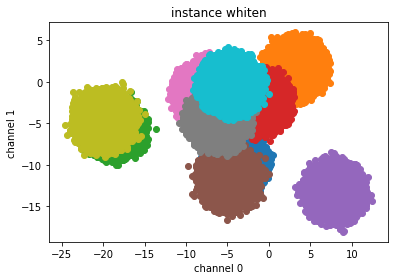

In [47]:
def instance_whiten(batch_feature_map):
    """zca whiten each feature map within individual image in batch"""
    y = flatten_space(batch_feature_map)
    y, mu = demean(y)
    N = y.shape[-1]
    cov = torch.einsum('bcx, bdx -> bcd', y, y) / (N-1)  # compute covs along batch dim
    u, lambduh, _ = torch.svd(cov)
    lambduh_inv_sqrt = torch.diag_embed(lambduh**(-.5))
    zca_whitener = torch.einsum('nab, nbc, ncd -> nad', u, lambduh_inv_sqrt, u.transpose(-2,-1))
    z = torch.einsum('bac, bcx -> bax', zca_whitener, y)
    return unflatten_space(mu + z)

_, ax = feature_scatter(instance_whiten(activations), nrows=1, ncols=1)
ax[0,0].set(title='instance whiten');

instance_whitened = flatten_batch_and_space(instance_whiten(activations))
demean_instance_whitened, _ = demean(instance_whitened)
print('Global cov should NOT be identity: \n',
      demean_instance_whitened @ demean_instance_whitened.T / instance_whitened.shape[-1])

After instance whitening, each instance is circular, but the global covariance across the batch remains.

## Batch whitening then instance whitening

What happens if we chain the whitening operations?
First I'll try batch -> instance.
The data is all scaled down and rotated, then each local distribution is spherized.

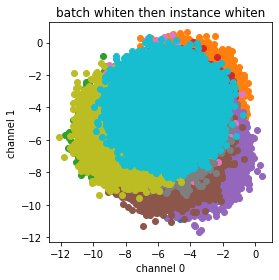

In [43]:
_, ax = feature_scatter(instance_whiten(batch_whiten(activations)), nrows=1, ncols=1)
ax[0,0].set(title='batch whiten then instance whiten');

## Instance whitening then batch whitening
Next I'll try instance -> batch whitening.

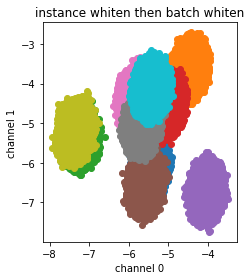

In [44]:
_, ax = feature_scatter(batch_whiten(instance_whiten(activations)), nrows=1, ncols=1);
ax[0,0].set(title='instance whiten then batch whiten');

In this case, the local circles are destroyed and turned elliptical again by the global whitening.

# Summary
Batch and instance whitening are both useful tools in machine learning.
Whether one is better than the other depends on your use-case.
There is an [interesting paper using what they call "Switchable whitening"](https://arxiv.org/abs/1904.09739) that
proposes to use a weighting of both, showing that the relative weighting depends on the task.

Their implementation is different than the cascaded forms of whitening I showed here, which might also be interesting
to look into deeper.
